In [ ]:
import pandas as pd

train = pd.read_parquet('/kaggle/input/avito-reranker/train-dset.parquet')


## Красткое описание решения

Для решения задачи использвуется модель CatBoostRanker, реализующая архитектуру , которая позволяет оптимизировать конкретные метрики, в том числе NDCG@10.

## Обработка датасета

### Заполнение пропусков, приведение типов

In [5]:
train.head(10)

,query_id,item_id,query_text,item_title,item_description,query_cat,query_mcat,query_loc,item_cat_id,item_mcat_id,item_loc,price,item_query_click_conv,item_contact
0,4,7349717282,ботинки детские zara 21,Ботинки детские Zara,Новые полуботинки фирмы Zara. \nразмеры 21 сте...,29.0,38.0,624480.0,29,2179540,638660,500.0,-1.0,0.0
1,4,7519735286,ботинки детские zara 21,Детские ботинки Zara унисекс,"Крутые ботинки, в отличном состоянии",29.0,38.0,624480.0,29,2179540,637640,250.0,-1.0,0.0
2,4,4384449104,ботинки детские zara 21,Ботинки детские zara,Челси димесезонные Zara \nВ идеальном состояни...,29.0,38.0,624480.0,29,2179540,623880,1500.0,-1.0,0.0
3,4,7283365509,ботинки детские zara 21,Детские ботиночки Zara 21 размер,АВИТО ДОСТАВКА .21 РАЗМЕР.,29.0,38.0,624480.0,29,2179540,628530,220.0,-1.0,0.0
4,4,4452768560,ботинки детские zara 21,Детские ботиночки zara размер 21,Детские ботинки Zara \nРазмер 21 - 13 см\nСост...,29.0,38.0,624480.0,29,2179540,637640,1648.0,-1.0,1.0
5,4,7607943724,ботинки детские zara 21,Ботинки челси zara детские 21,"Ботиночки Zara из замши, носили мало. Немного ...",29.0,38.0,624480.0,29,2179540,637640,450.0,-1.0,0.0
6,4,7538499003,ботинки детские zara 21,Ботинки детские 21 размер,Ботиночки Zara весна-осень на мальчика в хорош...,29.0,38.0,624480.0,29,2179585,640860,700.0,-1.0,0.0
7,4,4699894907,ботинки детские zara 21,Детские ботинки Zara 21,Продаю замшевые полуботинки Zara в хорошем сос...,29.0,38.0,624480.0,29,2179585,644200,550.0,-1.0,0.0
8,4,7355922557,ботинки детские zara 21,Ботиночки детские Zara 21 р. Натуральные,Ботиночки Zara натуральные 21 р. Следы носки е...,29.0,38.0,624480.0,29,2179585,631870,100.0,-1.0,0.0
9,4,4043345112,ботинки детские zara 21,Ботинки детские и резиновые сапожки 21 22 размер,1. Ботиночки демисезонные от +17 до +10. Без у...,29.0,38.0,624480.0,29,2179585,638520,750.0,-1.0,0.0


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7781790 entries, 0 to 7781789
Data columns (total 14 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   query_id               int64  
 1   item_id                int64  
 2   query_text             object 
 3   item_title             object 
 4   item_description       object 
 5   query_cat              float32
 6   query_mcat             float64
 7   query_loc              float32
 8   item_cat_id            int32  
 9   item_mcat_id           int32  
 10  item_loc               int32  
 11  price                  float32
 12  item_query_click_conv  float32
 13  item_contact           float32
dtypes: float32(5), float64(1), int32(3), int64(2), object(3)
memory usage: 593.7+ MB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335348 entries, 0 to 335347
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   query_id               335348 non-null  int64  
 1   item_id                335348 non-null  int64  
 2   query_text             335348 non-null  object 
 3   item_title             335346 non-null  object 
 4   item_description       335346 non-null  object 
 5   query_cat              335348 non-null  float32
 6   query_mcat             259323 non-null  float64
 7   query_loc              335348 non-null  float32
 8   item_cat_id            335348 non-null  int32  
 9   item_mcat_id           335348 non-null  int32  
 10  item_loc               335348 non-null  int32  
 11  price                  335348 non-null  float32
 12  item_query_click_conv  335348 non-null  float32
dtypes: float32(4), float64(1), int32(3), int64(2), object(3)
memory usage: 24.3+ MB


И на train и на test наблюдаются несоответсвия в типах категориальных признаках между запросами и объявлениями

In [5]:
print(train.isnull().sum())
print(test.isnull().sum())

query_id                       0
item_id                        0
query_text                     0
item_title                   107
item_description             107
query_cat                      0
query_mcat               1761233
query_loc                      0
item_cat_id                    0
item_mcat_id                   0
item_loc                       0
price                          0
item_query_click_conv          0
item_contact                   0
dtype: int64
query_id                     0
item_id                      0
query_text                   0
item_title                   2
item_description             2
query_cat                    0
query_mcat               76025
query_loc                    0
item_cat_id                  0
item_mcat_id                 0
item_loc                     0
price                        0
item_query_click_conv        0
dtype: int64


Наблюдаются пропуски в item_title, item_description и query_mcat

In [9]:
import re

def count_words(text):
    if not isinstance(text, str):
        return 0
    return len(re.findall(r"\w+", text))

def prepare_dataset(df, is_train=True):
    df['item_title'] = df['item_title'].fillna("")
    df['item_description'] = df['item_description'].fillna("")
    df['query_mcat'] = df['query_mcat'].fillna(0.0)
    df["item_query_click_conv"].fillna(0.0)
    
    if 'item_contact' in df.colums:
        df['item_contact'] = df['item_contact'].astype("int8")

    df["query_loc"] = df["query_loc"].astype("int32")
    df["query_cat"] = df["query_cat"].astype("int32")
    df["query_mcat"] = df["query_mcat"].astype("int32")

    df["query_text"] = df["query_text"].astype(str)
    df["item_title"] = df["item_title"].astype(str)
    df["item_description"] = df["item_description"].astype(str)

In [ ]:
prepare_dataset(train)

In [9]:
train.head()

,query_id,item_id,query_text,item_title,item_description,query_cat,query_mcat,query_loc,item_cat_id,item_mcat_id,...,item_query_click_conv,item_contact,conv_missing,loc_match,item_cat_freq_in_query,item_mcat_freq_in_query,title_len,desc_len,price_log,price_bin
0,4,7349717282,ботинки детские zara 21,Ботинки детские Zara,Новые полуботинки фирмы Zara. \nразмеры 21 сте...,29,38,624480,29,2179540,...,-1.0,0,1,0,1.0,0.6,3,25,6.216606,1
1,4,7519735286,ботинки детские zara 21,Детские ботинки Zara унисекс,"Крутые ботинки, в отличном состоянии",29,38,624480,29,2179540,...,-1.0,0,1,0,1.0,0.6,4,5,5.525453,0
2,4,4384449104,ботинки детские zara 21,Ботинки детские zara,Челси димесезонные Zara \nВ идеальном состояни...,29,38,624480,29,2179540,...,-1.0,0,1,0,1.0,0.6,3,9,7.313887,1
3,4,7283365509,ботинки детские zara 21,Детские ботиночки Zara 21 размер,АВИТО ДОСТАВКА .21 РАЗМЕР.,29,38,624480,29,2179540,...,-1.0,0,1,0,1.0,0.6,5,4,5.398163,0
4,4,4452768560,ботинки детские zara 21,Детские ботиночки zara размер 21,Детские ботинки Zara \nРазмер 21 - 13 см\nСост...,29,38,624480,29,2179540,...,-1.0,1,1,0,1.0,0.6,5,20,7.407924,2


### Анализ признаков

In [ ]:
train['item_contact'].value_counts()

Таргет очень разреженный. Это может сказаться на процессе обучения. Посмотрим на количество запросов, которые имеют хотя бы одного кандидата с ненулевым таргетом.

In [ ]:
group_positive_counts = train.groupby('query_id')['item_contact'].sum()

groups_without_positives = group_positive_counts[group_positive_counts == 0]

num_groups_without_1 = len(groups_without_positives)

print("Количество групп без единиц:", num_groups_without_1)
print("Количество групп", train['query_id'].nunique())

Таких групп также очень мало. 

In [13]:
import matplotlib.pyplot as plt

plt.hist(train["price"], bins=100, alpha=0.5, label="original")
plt.legend()
plt.show()

count    7.781790e+06
mean     1.563658e+06
std      9.410203e+08
min      0.000000e+00
25%      6.000000e+02
50%      2.600000e+03
75%      1.310000e+04
max      1.000000e+12
Name: price, dtype: float64

Много маленьких цен.

In [14]:
import matplotlib.pyplot as plt

plt.hist(train["item_query_click_conv"], bins=100, alpha=0.5, label="original")
plt.legend()
plt.show()

count    7.781790e+06
mean    -8.375558e-01
std      3.665795e-01
min     -1.000000e+00
25%     -1.000000e+00
50%     -1.000000e+00
75%     -1.000000e+00
max      1.000000e+00
Name: item_query_click_conv, dtype: float64

item_click_conv в основном содержит значения -1.0, остальные значения распределены от 0 до 1. Это может означать, что значения -1.0 - пропуски.

In [6]:
print(train.groupby("loc_match")["item_contact"].mean())
print(train["loc_match"].value_counts(normalize=True))

loc_match
0    0.035623
1    0.053004
Name: item_contact, dtype: float32
loc_match
0    0.514723
1    0.485277
Name: proportion, dtype: float64


Доля совпадений в локациях высока, значит признак действительно категориальный.

## Построение признаков

CatBoostRanker сам работает с тектсовыми фичами, преобразуя их в числовые - BoW, BM25, NaiveBayes. Воспользуемся этим. Однако, данные признаки не учитывают длину предложений заголовоков и описаний. Интуитивно кажется, что этот признак имеет значение, так как по более развернутым описаниям отклик может быть больше. Добавим фичи title_len и desc_len.

Как уже было отмечено, item_query_click_conv много пропусков, добавим признак conv_missing.

Также добавим признаки совпадения локации (loc_match) частоты cat и mcat среди кандидатов запроса (item_cat_freq_in_query и item_mcat_freq_in_query)

Также чтобы немного нормализовать цены возьмем признаки price_log и price_bin.



In [ ]:
def build_features(df):
    df["conv_missing"] = (df["item_query_click_conv"] == -1.0).astype("int8")
    df["loc_match"] = (df["query_loc"] == df["item_loc"]).astype("int8")

    item_cat_count_in_query = df.groupby(['query_id', 'item_cat_id'])['item_id'].transform('count')
    query_total_items = df.groupby('query_id')['item_id'].transform('count')
    df['item_cat_freq_in_query'] = (item_cat_count_in_query / query_total_items).astype("float32")
    
    item_mcat_count_in_query = df.groupby(['query_id', 'item_mcat_id'])['item_id'].transform('count')
    df['item_mcat_freq_in_query'] = (item_mcat_count_in_query / query_total_items).astype("float32")

    df["title_len"] = df["item_title"].apply(count_words).astype("int16")
    
    df["desc_len"] = df["item_description"].apply(count_words).astype("int16")
    
    df['price_log'] = np.log1p(df["price"])
    
    df["price_bin"] = pd.qcut(df["price"], q=5, labels=False, duplicates="drop").astype("int8")


In [ ]:
build_features(train)

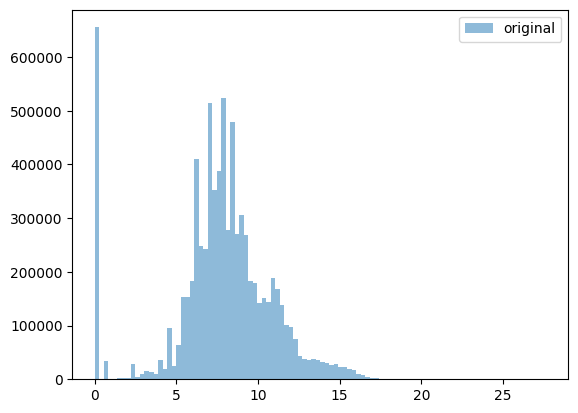

In [11]:
import matplotlib.pyplot as plt

plt.hist(train["price_log"], bins=100, alpha=0.5, label="original")
plt.legend()
plt.show()

In [14]:
train.head()

,query_id,item_id,query_text,item_title,item_description,query_cat,query_mcat,query_loc,item_cat_id,item_mcat_id,item_loc,price,item_query_click_conv,item_contact,conv_missing,loc_match,price_log,price_bin
0,4,7349717282,ботинки детские zara 21,Ботинки детские Zara,Ботинки детские Zara,624480,624480,624480,29,2179540,638660,500.0,-1.0,0.0,1,0,6.216606,1
1,4,7519735286,ботинки детские zara 21,Детские ботинки Zara унисекс,Детские ботинки Zara унисекс,624480,624480,624480,29,2179540,637640,250.0,-1.0,0.0,1,0,5.525453,0
2,4,4384449104,ботинки детские zara 21,Ботинки детские zara,Ботинки детские zara,624480,624480,624480,29,2179540,623880,1500.0,-1.0,0.0,1,0,7.313887,1
3,4,7283365509,ботинки детские zara 21,Детские ботиночки Zara 21 размер,Детские ботиночки Zara 21 размер,624480,624480,624480,29,2179540,628530,220.0,-1.0,0.0,1,0,5.398163,0
4,4,4452768560,ботинки детские zara 21,Детские ботиночки zara размер 21,Детские ботиночки zara размер 21,624480,624480,624480,29,2179540,637640,1648.0,-1.0,1.0,1,0,7.407924,2


Датасет большой, сохраним его, чтобы сэкономить ресурсы на kaggle :)

In [11]:
def make_cd_file(df, target_col, group_col, text_features, cat_features, ignore_features, filename="train.cd"):

    with open(filename, "w", encoding="utf-8") as f:
        for idx, col in enumerate(df.columns):
            if col == target_col:
                f.write(f"{idx}\tTarget\n")
            elif col == group_col:
                f.write(f"{idx}\tGroupId\n")
            elif col in ignore_features:
                f.write(f"{idx}\tAuxiliary\n")
            elif col in text_features:
                f.write(f"{idx}\tText\n")
            elif col in cat_features:
                f.write(f"{idx}\tCateg\n")
            else:
                f.write(f"{idx}\tNum\n")  # всё остальное считаем числовыми
    print(f"CD-файл сохранён как {filename}")

In [18]:
from sklearn.model_selection import train_test_split

df = train
cat_features = ['query_cat', 'query_mcat', 'query_loc',
                'item_cat_id', 'item_mcat_id', 'item_loc']
ignore_features = ['item_contact','query_id','item_id']
text_features = ['query_text', 'item_title', 'item_description']
features = [c for c in df.columns if c not in ignore_features]
target_col = 'item_contact'

unique_queries = df['query_id'].unique()
train_queries, val_queries = train_test_split(
    unique_queries, test_size=0.2, random_state=42
)

is_val = df['query_id'].isin(val_queries).to_numpy()

df = df.sort_values('query_id')

make_cd_file(df.loc[~is_val, features], target_col, 'query_id', text_features, cat_features, ignore_features)
make_cd_file(df.loc[is_val, features], target_col, 'query_id', text_features, cat_features, ignore_features, 'val.cd')

CD-файл сохранён как train.cd
CD-файл сохранён как val.cd


In [19]:
df.loc[~is_val, features].to_csv("train.csv", index=False)
df.loc[is_val, features].to_csv("val.csv", index=False)

In [ ]:
train.to_parquet(f"train_full.parquet", index=False, compression="snappy")

## Обучение

In [ ]:
import pandas as pd 
train = pd.read_parquet(f"/kaggle/input/avito-train-full/train_full.parquet")

In [9]:
# from sklearn.model_selection import GroupKFold
# from catboost import CatBoostRanker, Pool
# from sklearn.model_selection import train_test_split

# df = train

# cat_features = ['query_cat', 'query_mcat', 'query_loc',
#                 'item_cat_id', 'item_mcat_id', 'item_loc']
# ignore_features = ['item_contact','query_id','item_id']
# text_features = ['query_text', 'item_title', 'item_description']
# features = [col for col in df.columns if col not in ignore_features]
# target_col = 'item_contact'

# # уменьшение памяти
# for col in df.select_dtypes(include=["int64"]).columns:
#     df[col] = df[col].astype("int32")
# for col in df.select_dtypes(include=["float64"]).columns:
#     df[col] = df[col].astype("float32")
# for col in cat_features:
#     if col in df.columns:
#         df[col] = df[col].astype("category")

# # делим запросы
# unique_queries = df['query_id'].unique()
# train_queries, val_queries = train_test_split(unique_queries, test_size=0.2, random_state=42)

# # маска вместо добавления в df
# is_val = df["query_id"].isin(val_queries)

# # сортировка inplace
# df.sort_values("query_id", inplace=True)

# train_pool = Pool(
#     data=df.loc[~is_val, features],
#     label=df.loc[~is_val, target_col],
#     group_id=df.loc[~is_val, "query_id"],
#     cat_features=[f for f in cat_features if f in features],
#     text_features=[f for f in text_features if f in features]
# )

# val_pool = Pool(
#     data=df.loc[is_val, features],
#     label=df.loc[is_val, target_col],
#     group_id=df.loc[is_val, "query_id"],
#     cat_features=[f for f in cat_features if f in features],
#     text_features=[f for f in text_features if f in features]
# )


In [4]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from catboost import CatBoostRanker, Pool

# df = train  # или загрузи из parquet

# cat_features = ['query_cat', 'query_mcat', 'query_loc',
#                 'item_cat_id', 'item_mcat_id', 'item_loc']
# ignore_features = ['item_contact','query_id','item_id']
# text_features = ['query_text', 'item_title', 'item_description']
# features = [col for col in df.columns if col not in ignore_features]
# target_col = 'item_contact'

# # возьмем только часть запросов (например, 20%)
# unique_queries = df['query_id'].unique()
# sampled_queries = np.random.choice(unique_queries, 
#                                    size=int(1 * len(unique_queries)), 
#                                    replace=False)

# df = df[df['query_id'].isin(sampled_queries)].copy()

# # делим запросы на train / val
# train_queries, val_queries = train_test_split(df['query_id'].unique(),
#                                               test_size=0.2,
#                                               random_state=42)

# df['is_val'] = df['query_id'].isin(val_queries)

# # сортировка по query_id (важно для CatBoostRanker)
# df = df.sort_values('query_id')

# train_pool = Pool(
#     data=df.loc[~df["is_val"], features],
#     label=df.loc[~df["is_val"], target_col],
#     group_id=df.loc[~df["is_val"], "query_id"],
#     cat_features=[f for f in cat_features if f in features],
#     text_features=[f for f in text_features if f in features]
# )

# val_pool = Pool(
#     data=df.loc[df["is_val"], features],
#     label=df.loc[df["is_val"], target_col],
#     group_id=df.loc[df["is_val"], "query_id"],
#     cat_features=[f for f in cat_features if f in features],
#     text_features=[f for f in text_features if f in features]
# )


In [1]:
import pandas as pd

train = pd.read_parquet('/kaggle/input/avito-train-full/train_full.parquet')

In [3]:
train.head()

,query_id,item_id,query_text,item_title,item_description,query_cat,query_mcat,query_loc,item_cat_id,item_mcat_id,...,item_query_click_conv,item_contact,conv_missing,loc_match,item_cat_freq_in_query,item_mcat_freq_in_query,title_len,desc_len,price_log,price_bin
0,4,7349717282,ботинки детские zara 21,Ботинки детские Zara,Новые полуботинки фирмы Zara. \nразмеры 21 сте...,29,38,624480,29,2179540,...,-1.0,0,1,0,1.0,0.6,3,25,6.216606,1
1,4,7519735286,ботинки детские zara 21,Детские ботинки Zara унисекс,"Крутые ботинки, в отличном состоянии",29,38,624480,29,2179540,...,-1.0,0,1,0,1.0,0.6,4,5,5.525453,0
2,4,4384449104,ботинки детские zara 21,Ботинки детские zara,Челси димесезонные Zara \nВ идеальном состояни...,29,38,624480,29,2179540,...,-1.0,0,1,0,1.0,0.6,3,9,7.313887,1
3,4,7283365509,ботинки детские zara 21,Детские ботиночки Zara 21 размер,АВИТО ДОСТАВКА .21 РАЗМЕР.,29,38,624480,29,2179540,...,-1.0,0,1,0,1.0,0.6,5,4,5.398163,0
4,4,4452768560,ботинки детские zara 21,Детские ботиночки zara размер 21,Детские ботинки Zara \nРазмер 21 - 13 см\nСост...,29,38,624480,29,2179540,...,-1.0,1,1,0,1.0,0.6,5,20,7.407924,2


In [2]:
len(train)

7781790

In [12]:
# train = train.groupby('query_id').filter(lambda g: g['item_contact'].sum() > 0)

In [2]:
df = train
group_stats = df.groupby("query_id")["item_contact"].sum().reset_index()
group_stats.rename(columns={"item_contact": "positive_cnt"}, inplace=True)

# 2️⃣ Делим группы на сигнальные и нулевые
positive_groups = group_stats[group_stats["positive_cnt"] > 0]["query_id"]
negative_groups = group_stats[group_stats["positive_cnt"] == 0]["query_id"]

# 3️⃣ Делаем downsampling нулевых групп (оставляем 50%)
sampled_negative_groups = negative_groups.sample(frac=0.15, random_state=42)

# 4️⃣ Собираем новый train
kept_groups = pd.concat([positive_groups, sampled_negative_groups])
train = df[df["query_id"].isin(kept_groups)]

In [3]:
train.head()

,query_id,item_id,query_text,item_title,item_description,query_cat,query_mcat,query_loc,item_cat_id,item_mcat_id,...,item_query_click_conv,item_contact,conv_missing,loc_match,item_cat_freq_in_query,item_mcat_freq_in_query,title_len,desc_len,price_log,price_bin
0,4,7349717282,ботинки детские zara 21,Ботинки детские Zara,Новые полуботинки фирмы Zara. \nразмеры 21 сте...,29,38,624480,29,2179540,...,-1.0,0,1,0,1.0,0.6,3,25,6.216606,1
1,4,7519735286,ботинки детские zara 21,Детские ботинки Zara унисекс,"Крутые ботинки, в отличном состоянии",29,38,624480,29,2179540,...,-1.0,0,1,0,1.0,0.6,4,5,5.525453,0
2,4,4384449104,ботинки детские zara 21,Ботинки детские zara,Челси димесезонные Zara \nВ идеальном состояни...,29,38,624480,29,2179540,...,-1.0,0,1,0,1.0,0.6,3,9,7.313887,1
3,4,7283365509,ботинки детские zara 21,Детские ботиночки Zara 21 размер,АВИТО ДОСТАВКА .21 РАЗМЕР.,29,38,624480,29,2179540,...,-1.0,0,1,0,1.0,0.6,5,4,5.398163,0
4,4,4452768560,ботинки детские zara 21,Детские ботиночки zara размер 21,Детские ботинки Zara \nРазмер 21 - 13 см\nСост...,29,38,624480,29,2179540,...,-1.0,1,1,0,1.0,0.6,5,20,7.407924,2


In [5]:
len(train)

3480520

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import Pool

# используем сразу весь train
df = train 

cat_features = ['query_cat', 'query_mcat', 'query_loc',
                'item_cat_id', 'item_mcat_id', 'item_loc']
ignore_features = ['item_contact','query_id','item_id']
text_features = ['query_text', 'item_title', 'item_description']
features = [c for c in df.columns if c not in ignore_features]
target_col = 'item_contact'

# делим запросы на train / val по query_id (чтобы не было утечки)
unique_queries = df['query_id'].unique()
train_queries, val_queries = train_test_split(
    unique_queries, test_size=0.1, random_state=42
)

is_val = df['query_id'].isin(val_queries).to_numpy()

# сортировка по query_id (важно для CatBoostRanker)
df = df.sort_values('query_id')

# query_item_contact = df[['query_id', target_col]]

# group_weights_series = (
#     query_item_contact.groupby("query_id")[target_col]
#     .agg(lambda x: 2.0 if x.sum() > 0 else 1.0)
# )

# # Маппим веса обратно к каждой строке
# weights_per_row = df["query_id"].map(group_weights_series)

# # Теперь длина weights_per_row = длине df
# train_weights = weights_per_row.loc[~is_val]
# val_weights = weights_per_row.loc[is_val]

# вместо создания новых датафреймов используем маски
train_pool = Pool(
    data=df.loc[~is_val, features],
    label=df.loc[~is_val, target_col],
    group_id=df.loc[~is_val, "query_id"],
    cat_features=[f for f in cat_features if f in features],
    text_features=[f for f in text_features if f in features],
)

val_pool = Pool(
    data=df.loc[is_val, features],
    label=df.loc[is_val, target_col],
    group_id=df.loc[is_val, "query_id"],
    cat_features=[f for f in cat_features if f in features],
    text_features=[f for f in text_features if f in features],
)


In [7]:
import numpy as np
import pandas as pd
from catboost import Pool

# используем весь train
df = train.copy()

cat_features = ['query_cat', 'query_mcat', 'query_loc',
                'item_cat_id', 'item_mcat_id', 'item_loc']
ignore_features = ['item_contact','query_id','item_id']
text_features = ['query_text', 'item_title', 'item_description']
features = [c for c in df.columns if c not in ignore_features]
target_col = 'item_contact'

# сортировка по query_id (важно для CatBoostRanker)
df = df.sort_values('query_id')

# считаем group_weight: если в группе есть хотя бы один контакт, вес=2, иначе=1
group_weights_series = (
    df.groupby("query_id")[target_col]
      .agg(lambda x: 2.0 if x.sum() > 0 else 1.0)
)

# маппим веса обратно к каждой строке
weights_per_row = df["query_id"].map(group_weights_series)

# финальный пул
train_pool = Pool(
    data=df[features],
    label=df[target_col],
    group_id=df["query_id"],
    cat_features=[f for f in cat_features if f in features],
    text_features=[f for f in text_features if f in features],
    group_weight=weights_per_row
)


In [6]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from catboost import Pool

# # df уже уменьшен заранее
# df = train  

# cat_features = ['query_cat', 'query_mcat', 'query_loc',
#                 'item_cat_id', 'item_mcat_id', 'item_loc']
# ignore_features = ['item_contact', 'query_id', 'item_id']
# text_features = ['query_text', 'item_title', 'item_description']
# target_col = 'item_contact'

# # Список признаков для модели
# features = [c for c in df.columns if c not in ignore_features]

# # Делим по уникальным query_id (группы не пересекаются между train/val)
# unique_queries = df['query_id'].unique()
# train_queries, val_queries = train_test_split(
#     unique_queries, test_size=0.2, random_state=42
# )

# is_val = df['query_id'].isin(val_queries).to_numpy()

# # Сортируем по query_id (важно, чтобы группы шли подряд)
# df = df.sort_values('query_id')

# # ---------------------------
# # Формируем group_weight
# # ---------------------------

# # Берем только нужные колонки, чтобы не держать в памяти весь df
# query_item_contact = df[['query_id', target_col]]

# # Группируем по query_id (один вес на группу)
# group_weights_series = (
#     query_item_contact.groupby("query_id")[target_col]
#     .agg(lambda x: 2.0 if x.sum() > 0 else 1.0)
# )

# # Создаём массивы весов для train и val
# train_group_weights = group_weights_series.loc[train_queries].values
# val_group_weights = group_weights_series.loc[val_queries].values

# # ---------------------------
# # Создаем Pool без копирования df
# # ---------------------------

# train_pool = Pool(
#     data=df.loc[~is_val, features],
#     label=df.loc[~is_val, target_col],
#     group_id=df.loc[~is_val, "query_id"],
#     group_weight=train_group_weights,
#     cat_features=[f for f in cat_features if f in features],
#     text_features=[f for f in text_features if f in features],
# )

# val_pool = Pool(
#     data=df.loc[is_val, features],
#     label=df.loc[is_val, target_col],
#     group_id=df.loc[is_val, "query_id"],
#     group_weight=val_group_weights,
#     cat_features=[f for f in cat_features if f in features],
#     text_features=[f for f in text_features if f in features],
# )


CatBoostError: Length of group_weight=368250 and length of data=4316560 are different.

In [1]:
import pandas as pd

train = pd.read_parquet("/kaggle/input/avito-train-full/train_full.parquet")

In [2]:
train['weight'] = train['item_contact'].apply(lambda x: 10 if x == 1 else 1)

In [5]:
from sklearn.model_selection import train_test_split

df = train
cat_features = ['query_cat', 'query_mcat', 'query_loc',
                'item_cat_id', 'item_mcat_id', 'item_loc']
ignore_features = ['item_contact','query_id','item_id']
text_features = ['query_text', 'item_title', 'item_description']
features = [c for c in df.columns if c not in ignore_features]
target_col = 'item_contact'

unique_queries = df['query_id'].unique()
train_queries, val_queries = train_test_split(
    unique_queries, test_size=0.2, random_state=42
)

is_val = df['query_id'].isin(val_queries).to_numpy()

df = df.sort_values('query_id')

In [7]:
from catboost import Pool, CatBoostRanker

train_pool = Pool(
    data="tmp.csv",
    column_description="/kaggle/input/avito-train-val/train.cd",
    delimiter=",",
    has_header=True,
)

val_pool = Pool(
    data="/kaggle/input/avito-train-val/val.csv",
    column_description="/kaggle/input/avito-train-val/val.cd",
    delimiter=",",
    has_header=True,
)


CatBoostError: cat_features, text_features, embedding_features, embedding_features_data, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, label should have the None type when the pool is read from the file.

In [5]:
from catboost import CatBoostRanker

model = CatBoostRanker(
        iterations=3000,
        learning_rate=0.03,
        depth=5,
        loss_function="YetiRank",
        eval_metric="NDCG:top=10",
        l2_leaf_reg=6,
        random_strength=0.8,
        bootstrap_type="Bayesian",
        bagging_temperature=1.5,
        random_seed=42,
        task_type="GPU",
        devices="0",
        early_stopping_rounds=200,
        verbose=200,
        metric_period=50,
    )


In [7]:
model.fit(train_pool, eval_set=val_pool, use_best_model=True)

Groupwise loss function. OneHotMaxSize set to 10


Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7337787	best: 0.7337787 (0)	total: 908ms	remaining: 45m 21s
200:	test: 0.7779320	best: 0.7779341 (199)	total: 2m 24s	remaining: 33m 30s
400:	test: 0.7884357	best: 0.7884357 (400)	total: 4m 31s	remaining: 29m 19s
600:	test: 0.7907442	best: 0.7907442 (600)	total: 6m 20s	remaining: 25m 20s
800:	test: 0.7919595	best: 0.7919689 (797)	total: 7m 58s	remaining: 21m 52s
1000:	test: 0.7926891	best: 0.7926891 (1000)	total: 9m 34s	remaining: 19m 7s
1200:	test: 0.7932186	best: 0.7932262 (1199)	total: 11m 4s	remaining: 16m 35s
1400:	test: 0.7937250	best: 0.7937466 (1349)	total: 12m 32s	remaining: 14m 18s
1600:	test: 0.7940152	best: 0.7940515 (1594)	total: 13m 58s	remaining: 12m 12s
1800:	test: 0.7942848	best: 0.7943030 (1797)	total: 15m 20s	remaining: 10m 12s
2000:	test: 0.7944615	best: 0.7945451 (1965)	total: 16m 38s	remaining: 8m 18s
2200:	test: 0.7946457	best: 0.7946571 (2125)	total: 17m 57s	remaining: 6m 31s
2400:	test: 0.7948480	best: 0.7948509 (2356)	total: 19m 17s	remaining: 4m 48s

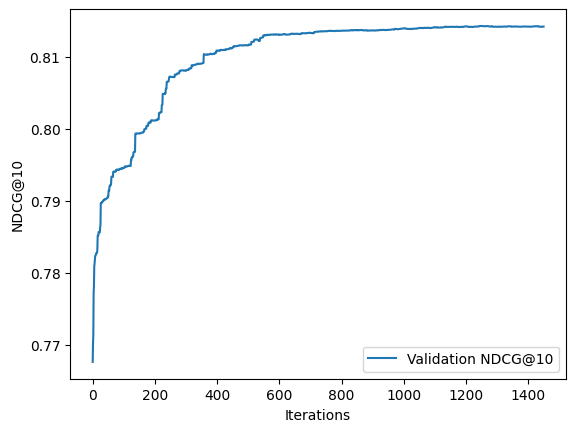

In [9]:
import matplotlib.pyplot as plt

history = model.get_evals_result()

val_metric_key = list(history['validation'].keys())[0]

val_scores = history['validation'][val_metric_key]

plt.plot(val_scores, label="Validation NDCG@10")
plt.xlabel("Iterations")
plt.ylabel("NDCG@10")
plt.legend()
plt.show()

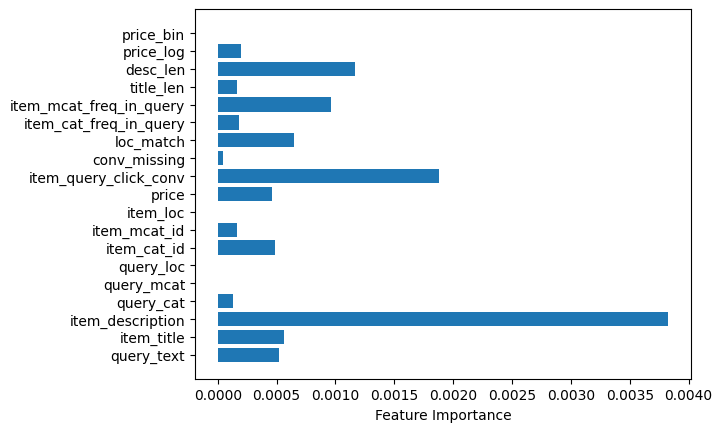

In [17]:
# feat_imp = model.get_feature_importance(train_pool, type='FeatureImportance')
import matplotlib.pyplot as plt

plt.barh(features, feat_imp)
plt.xlabel("Feature Importance")
plt.show()

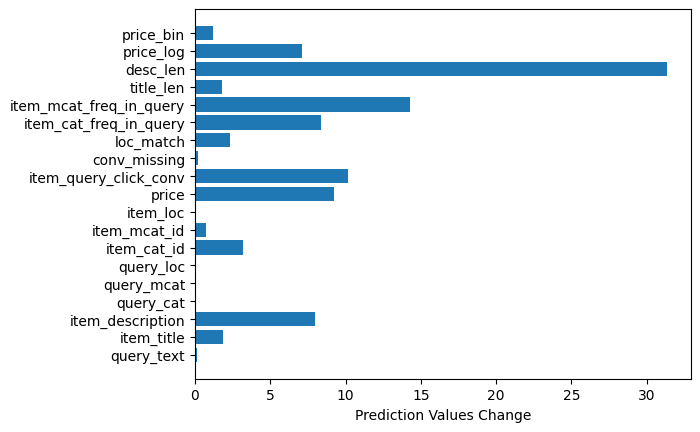

In [11]:
feat_imp = model.get_feature_importance(train_pool, type='PredictionValuesChange')
plt.barh(features, feat_imp)
plt.xlabel("Prediction Values Change")
plt.show()

In [12]:
 model.save_model(f"catboost_model.cbm")

In [8]:
test = pd.read_parquet('/kaggle/input/avito-reranker/test-dset-small.parquet')

In [30]:
test.head()

,query_id,item_id,query_text,item_title,item_description,query_cat,query_mcat,query_loc,item_cat_id,item_mcat_id,item_loc,price,item_query_click_conv
0,55,7540855789,1 сентября,Воздушные и гелиевые шары на 1 сентября,ВОЗДУШНЫЕ ШАРЫ К 1 СЕНТЯБРЯ 🍂\n\n🎒 Друзья! Мы ...,114.0,63.0,637640.0,114,2301564,637640,120.0,-1.0
1,55,7506720336,1 сентября,1 сентября фотозона,🎈Фотозона из шаров на 1 сентября – создайте пр...,114.0,63.0,637640.0,114,2301564,637640,5000.0,-1.0
2,55,3110733862,1 сентября,Букет на 1 сентября из зефира,Букеты на 1 сентября \n\nФото 1. Букет Пионов ...,114.0,63.0,637640.0,114,1090077,637640,1200.0,-1.0
3,55,7587733901,1 сентября,Спектакль-пантомима на 1 сентября,Спектакль-пантомима на 1 сентября!\n\n👍🏼Идеаль...,114.0,63.0,637640.0,114,2301563,637640,0.0,-1.0
4,55,7552455685,1 сентября,Воздушные гелиевые шары с доставкой 1 сентября,Воздушные шары для оформления школ и классов н...,114.0,63.0,637640.0,114,2301564,637640,100.0,-1.0


In [10]:
prepare_dataset(test, False)
build_features(test)

In [11]:
cat_features = ['query_cat', 'query_mcat', 'query_loc',
                'item_cat_id', 'item_mcat_id', 'item_loc']
ignore_features = ['item_contact','query_id','item_id']
text_features = ['query_text', 'item_title', 'item_description']
features = [c for c in df.columns if c not in ignore_features]
target_col = 'item_contact'

test_pool = Pool(
    data=test[features],
    group_id=test["query_id"],
    cat_features=[f for f in cat_features if f in features],
    text_features=[f for f in text_features if f in features]
)
preds = model.predict(test_pool)

In [12]:
test["pred"] = preds

submission = (
    test
    .sort_values(["query_id", "pred"], ascending=[True, False])
    .loc[:, ["query_id", "item_id"]]
)
submission.head()

,query_id,item_id
11,55,7464296355
22,55,7562354327
15,55,823036541
14,55,7555956997
8,55,7552064016


In [13]:
submission.to_csv("submission.csv", index=False)

In [14]:
from catboost import Pool
test = pd.read_parquet('/kaggle/input/avito-reranker/test-dset-small.parquet')
prepare_dataset(test, False)
build_features(test)

cat_features = ['query_cat', 'query_mcat', 'query_loc',
                'item_cat_id', 'item_mcat_id', 'item_loc']
ignore_features = ['item_contact','query_id','item_id']
text_features = ['query_text', 'item_title', 'item_description']
features = [c for c in df.columns if c not in ignore_features]

test_pool = Pool(
    data=test[features],
    group_id=test["query_id"],
    cat_features=[f for f in cat_features if f in features],
    text_features=[f for f in text_features if f in features]
)

test["pred"] = model.predict(test_pool)

test["rank"] = (
    test.groupby("query_id")["pred"]
        .rank(method="first", ascending=False)
        .astype("int32")
)

submission = test.loc[:, ["query_id", "item_id"]]

submission.to_csv("submission.csv", index=False)


In [16]:
submission = test.loc[:, ["query_id", "item_id"]]

submission.to_csv("submission.csv", index=False)
